### Starting over with the LSTM model ... 

This time I wanna be weird with the architecture, hold up lol. 
File initially created 6/26/2025. 

I will start with a 14 day model. 

In [1]:
##import cell makes its appearance once again...
%matplotlib inline
##so-called "math" related imports
#from netCDF4 import Dataset as ncread
import numpy as np
import pandas as pd
import math
from random import seed
from random import randint
from random import sample
from scipy.ndimage import gaussian_filter
from sklearn.metrics import brier_score_loss
import xarray as xr

import pickle

##plotting related imports
import matplotlib.pyplot as plt

#import tensorflow/keras related files
import tensorflow as tf    
#tf.compat.v1.disable_v2_behavior() # <-- HERE !

tf.device('/physical_device:GPU:0')

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import regularizers
import tensorflow.keras.backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dropout, Activation, Reshape, Flatten, LSTM, Dense, Dropout, Embedding, Bidirectional, GRU, Concatenate
from tensorflow.keras import Sequential
from tensorflow.keras import initializers, regularizers
from tensorflow.keras import optimizers
from tensorflow.keras import constraints
from tensorflow.keras.layers import Layer, InputSpec

tf.compat.v1.disable_eager_execution()
#import investigate

2025-06-27 15:26:03.187089: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-27 15:26:03.189103: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-27 15:26:03.216204: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-27 15:26:03.216225: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-27 15:26:03.216244: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

In [2]:
print(tf.__version__)

2.14.1


In [3]:
##load in solvers for PC analysis to get the PCs for the model itself. 

In [4]:
# load input solvers
infile = open("../../reduced_data/PCs/U_14.p","rb",)
U_PC = pickle.load(infile)  ##zonal mean wind
infile.close()

infile = open("../../reduced_data/PCs/EHF_14.p","rb",)
EHF_PC = pickle.load(infile)  ##ZMehf vertical cross section along longitudes
infile.close()

infile = open("../../reduced_data/PCs/GPH_14.p","rb",)
GPH_PC = pickle.load(infile)  ##ZMehf vertical cross section along longitudes
infile.close()

In [5]:
##remove PC 1
U_PC = U_PC[:, 1:]
EHF_PC = EHF_PC[:, 1:]
GPH_PC = GPH_PC[:, 1:]

In [6]:
u_indices = [1,0,2,6]
gph_indices = [2,0,3]
ehf_indices = [0,22,17,5,11,2,29,12,9,6,13,3,4]

U_PC = np.take(U_PC, u_indices, axis = 1)
EHF_PC = np.take(EHF_PC, ehf_indices, axis = 1)
GPH_PC = np.take(GPH_PC, gph_indices, axis = 1)

In [7]:
U_PC = U_PC.reshape((62,149,4))
GPH_PC = GPH_PC.reshape((62,149,3))
EHF_PC = EHF_PC.reshape((62,149,13))

In [8]:
U_PC.shape

(62, 149, 4)

In [9]:
# load output data
infile = open("../../reduced_data/temps/eur_14.p","rb",)
output = pickle.load(infile) 
infile.close()

In [10]:
output.shape

(9238,)

In [11]:
##need to change this based on lag 
## 14-days = [:, 10:] 10 day window rather than 14
## 20-days = [:, 16:]
## 30-days = [:, 26:]

# 139
# 133
# 123

## 14-days = [:, 14:] 14 day window
## 20-days = [:, 20:]
## 30-days = [:, 30:]

# 135
# 129
# 119

lead = 135

temp = output.reshape(62, 149)
temp = temp[:, 14:]
print(temp.shape)

temp_flat = temp.flatten()

(62, 135)


In [12]:
#create timeseries data arrays for PCs 
#was 122 and 14 for the 14 day window. 

new_input1 =  np.empty((62,lead,14,4))
new_input2 =  np.empty((62,lead,14,13))
new_input3 =  np.empty((62,lead,14,3))

new_output = np.empty((62,lead))

for i in range(0,62):
    for j in range(0,lead):
        new_input1[i,j,:,:] = U_PC[i,j:j+14,:]
        new_input2[i,j,:,:] = EHF_PC[i,j:j+14,:]
        new_input3[i,j,:,:] = GPH_PC[i,j:j+14,:]
        
        new_output[i,j] = temp[i,j]

In [13]:
new_input1 = np.array(new_input1)
new_input2 = np.array(new_input2)
new_input3 = np.array(new_input3)

new_output = np.array(new_output)
print(new_input1.shape)
print(new_output.shape)

(62, 135, 14, 4)
(62, 135)


In [14]:
frac_ind = round((62*lead)*0.15)
frac_end = round((62*lead)-frac_ind)
frac_end

7114

In [15]:
frac_ind

1256

In [16]:
##Set X_all and Y_all datasets
X_all1 = np.copy(new_input1.reshape((62*lead),14,4))
X_all2 = np.copy(new_input2.reshape((62*lead),14,13))
X_all3 = np.copy(new_input3.reshape((62*lead),14,3))

Y_all = np.copy(new_output.flatten())

##training data partition out
X_tri1 = X_all1[:frac_end,:] ##u
X_tri2 = X_all2[:frac_end,:] ##ehf
X_tri3 = X_all3[:frac_end,:] ##gph

Y_tri = Y_all[:frac_end]

#testing data partition out
X_tes1 = X_all1[frac_end:,:]
X_tes2 = X_all2[frac_end:,:]
X_tes3 = X_all3[frac_end:,:]

Y_tes = Y_all[frac_end:]

#Convert the Y array into a categorical array. This means we will create one-hot vector labels for all of the inputs.
# The one-hot vectors have an index for each possible output category (two in our case)
# A "1" is put in the index corresponding to the category to which the sample belongs
Y_all = keras.utils.to_categorical(Y_all)
Y_tri = keras.utils.to_categorical(Y_tri)
Y_tes= keras.utils.to_categorical(Y_tes)

In [17]:
Y_all.shape

(8370, 2)

In [18]:
##checking my data for NaN of Infs because I need to make sure this doesn't cause
#the model to throw back no loss

if np.any(np.isnan(X_all1)) or np.any(np.isinf(X_all1)):
    print("NaN or Inf values found in X_all!")

if np.any(np.isnan(Y_all)) or np.any(np.isinf(Y_all)):
    print("NaN or Inf values found in Y_all!")

### Begin establishing specifics of model.

In [19]:
##class weight creator for the instance where now I have a four dimensional output array 
def class_weight_creator(Y):
    class_dict = {}
    Y_reshaped = Y.reshape(-1, Y.shape[-1])
    weights = np.max(np.sum(Y_reshaped, axis=0)) / np.sum(Y_reshaped, axis=0)
    for i in range(Y.shape[-1] ):
        class_dict[i] = weights[i]
        
    return class_dict

In [20]:
##number of input nodes
input_shape1=  X_all1.shape[1:] # u
input_shape2= X_all2.shape[1:] ## ehf
input_shape3= X_all3.shape[1:] ## gph


##fraction of training data
X_validation1 = X_tri1[0:frac_ind]
X_validation2 = X_tri2[0:frac_ind]
X_validation3 = X_tri3[0:frac_ind]
Y_validation = Y_tri[0:frac_ind]
        
X_train1 = X_tri1[frac_ind:len(X_tri1)]
X_train2 = X_tri2[frac_ind:len(X_tri2)]
X_train3 = X_tri3[frac_ind:len(X_tri3)]
Y_train = Y_tri[frac_ind:len(Y_tri)]

X_test1 = X_tes1
X_test2 = X_tes2
X_test3 = X_tes3
Y_test = Y_tes

In [21]:
Y_train.shape

(5858, 2)

In [22]:
input_shape1

(14, 4)

### Model Architecture. 

In [23]:
##dictionaries for training and validation
X_train = {'layer1': X_train1, 'layer2': X_train2, 'layer3': X_train3}
X_all = {'layer1': X_all1, 'layer2': X_all2, 'layer3': X_all3}
X_test = {'layer1': X_test1, 'layer2': X_test2, 'layer3': X_test3}
X_val = {'layer1': X_validation1, 'layer2': X_validation2, 'layer3': X_validation3}

In [24]:
######
batch_size = 64 #The number of samples the network sees before it backpropagates (batch size)
epochs = 30 #The number of times the network will loop through the entire dataset (epochs)
shuffle = True #Set whether to shuffle the training data so the model doesn't see it sequentially 
verbose = 2 #Set whether the model will output information when trained (0 = no output; 2 = output accuracy every epoch)

In [25]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [26]:
#model
def combined_LSTM(n1, n2, n3, n4, rl1, rl2, rl3, rl4, learn): 
    #first layer
    input_tensor1 = Input(shape=(14,4), name = 'layer1')
    
    layer1 = layers.RNN(
        layers.LSTMCell(n1, activation='tanh', use_bias=True,
                          dropout=0.331, 
                          kernel_initializer='glorot_uniform',
                          kernel_regularizer=keras.regularizers.l2(l2= rl1)),
        return_sequences=False)(input_tensor1)
       
    #second layer
    input_tensor2 = Input(shape=(14,13), name = 'layer2')
    
    layer2 = layers.RNN(
        layers.LSTMCell(n2, activation='tanh', use_bias=True,
                          dropout=0.331, 
                          kernel_initializer='glorot_uniform',
                          kernel_regularizer=keras.regularizers.l2(l2= rl2)),
        return_sequences=False)(input_tensor2)
    
    #third layer
    input_tensor3 = Input(shape=(14,3), name = 'layer3')
    
    layer3 = layers.RNN(
        layers.LSTMCell(n3, activation='tanh', use_bias=True,
                          dropout=0.331, 
                          kernel_initializer='glorot_uniform',
                          kernel_regularizer=keras.regularizers.l2(l2= rl3)),
        return_sequences=False)(input_tensor3)
    
     ##combine two model inputs
    merge_layer = Concatenate()([layer1,layer2,layer3])
    
    ##more dense layers
    merge = layers.Dense(n4, activation='relu', use_bias=True,
                          kernel_initializer='he_normal',bias_initializer='he_normal',
                          kernel_regularizer=keras.regularizers.l2(l2= rl4))(merge_layer)

    #decay_rate = learn / epochs
    output_tensor = layers.Dense(2,activation='softmax')(merge)
    model = Model([input_tensor1, input_tensor2, input_tensor3], output_tensor)
    model.compile(optimizer=keras.optimizers.legacy.Adam(learning_rate=learn),
              loss = 'categorical_crossentropy', #Our loss function is based on categorical error
              metrics=[keras.metrics.categorical_accuracy], #We will print out the categorical accuracy as the network is trained
              )
    return model

In [37]:
tf.keras.backend.clear_session()

In [38]:
#model = combined_LSTM(16,80,32,64,0.019,0.073,0.004,0.002,0.043)
model = combined_LSTM(112,16,64,64,0.0048,0.054,0.0033,0.0062,0.246)

In [39]:
##do the class_dict weights
class_weight = class_weight_creator(Y_train)
class_weight

{0: 1.0, 1: 1.8068999}

In [40]:
model.fit(X_train, Y_train, validation_data=(X_val, Y_validation),
          batch_size=batch_size, epochs=epochs, class_weight=class_weight, shuffle=shuffle)#, callbacks=[stop_early])

Train on 5858 samples, validate on 1256 samples
Epoch 1/30


2025-06-27 15:27:34.638152: W tensorflow/c/c_api.cc:305] Operation '{name:'training/Adam/rnn_2/lstm_cell_2/recurrent_kernel/v/Assign' id:2145 op device:{requested: '', assigned: ''} def:{{{node training/Adam/rnn_2/lstm_cell_2/recurrent_kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/Adam/rnn_2/lstm_cell_2/recurrent_kernel/v, training/Adam/rnn_2/lstm_cell_2/recurrent_kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


5824/5858 [============================>.] - ETA: 0s - loss: 25.6295 - categorical_accuracy: 0.4845

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


5858/5858 [==============================] - 1s 238us/sample - loss: 25.6552 - categorical_accuracy: 0.4853 - val_loss: 27.4951 - val_categorical_accuracy: 0.3288
Epoch 2/30
5858/5858 [==============================] - 1s 150us/sample - loss: 10.3406 - categorical_accuracy: 0.5051 - val_loss: 2.2815 - val_categorical_accuracy: 0.3201
Epoch 3/30
5858/5858 [==============================] - 1s 149us/sample - loss: 1.8784 - categorical_accuracy: 0.5113 - val_loss: 1.3361 - val_categorical_accuracy: 0.3201
Epoch 4/30
5858/5858 [==============================] - 1s 148us/sample - loss: 1.3609 - categorical_accuracy: 0.4891 - val_loss: 1.0213 - val_categorical_accuracy: 0.6799
Epoch 5/30
5858/5858 [==============================] - 1s 147us/sample - loss: 1.1665 - categorical_accuracy: 0.4997 - val_loss: 0.8632 - val_categorical_accuracy: 0.6799
Epoch 6/30
5858/5858 [==============================] - 1s 148us/sample - loss: 1.0662 - categorical_accuracy: 0.5024 - val_loss: 0.7864 - val_categ

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2025-06-27 15:28:01.384015: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_1/Softmax' id:1350 op device:{requested: '', assigned: ''} def:{{{node dense_1/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_1/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


<bound method Axes.legend of <Axes: title={'center': 'Accuracy'}, xlabel='Epoch', ylabel='Acc'>>

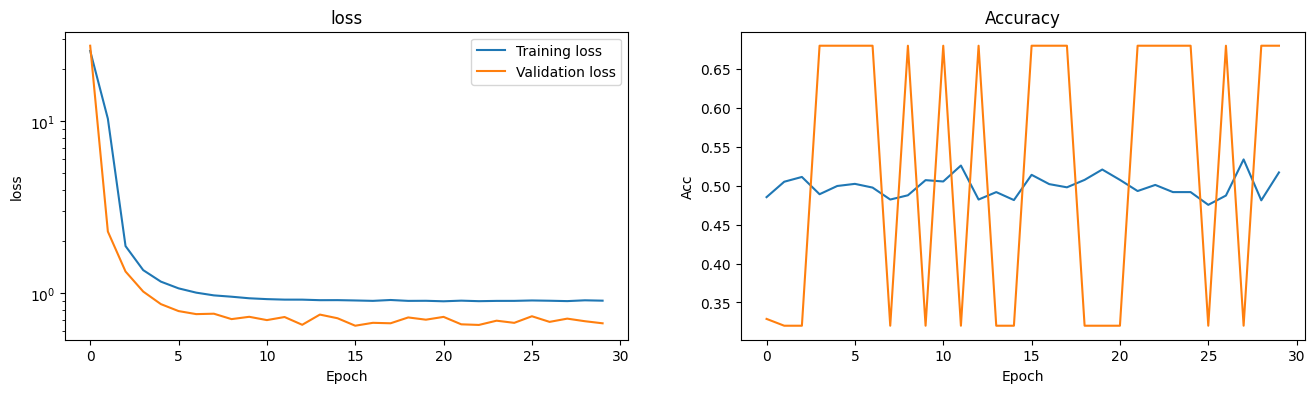

In [41]:
train_loss=model.history.history['loss']
val_loss=model.history.history['val_loss']
    
cat_acc=model.history.history['categorical_accuracy']
val_acc=model.history.history['val_categorical_accuracy']
        
pred = model.predict(X_all)
pred_val = model.predict(X_val)
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)

# Look at the optimization history
fig, (ax1,ax2) = plt.subplots(1,2, figsize=plt.figaspect(0.25))
ax1.plot(train_loss, label='Training loss')
ax1.plot(val_loss, label='Validation loss')
ax1.set_yscale('log')
ax1.set_title('loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('loss')
ax1.legend()

ax2.plot(cat_acc, label='Training ACC')
ax2.plot(val_acc, label='Validation ACC')
ax2.set_title('Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Acc')
ax2.legend
#plt.savefig("SEUS_onearch.png")

In [42]:
from sklearn.metrics import classification_report
import numpy as np

y_val_pred = model.predict(X_val)
y_val_classes = np.argmax(y_val_pred, axis=1)
y_val_true = np.argmax(Y_validation, axis=1)

print(classification_report(y_val_true, y_val_classes, digits=3))

              precision    recall  f1-score   support

           0      0.680     1.000     0.809       854
           1      0.000     0.000     0.000       402

    accuracy                          0.680      1256
   macro avg      0.340     0.500     0.405      1256
weighted avg      0.462     0.680     0.550      1256



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [43]:
# Convert one-hot labels to 1D integer labels (0 or 1)
y_true = np.argmax(Y_test, axis=1)

# Extract predicted probability for the positive class (class 1)
y_prob = pred_test[:,1]

# Create climatology baseline: constant probability = mean positive class rate
p_climatology = np.full_like(y_true, y_true.mean(), dtype=float)

# Compute Brier Scores
bs_model = brier_score_loss(y_true, y_prob)
bs_climo = brier_score_loss(y_true, p_climatology)

# Compute Brier Skill Score
bss = 1 - (bs_model / bs_climo)

print(f"Brier Score (Model): {bs_model:.4f}")
print(f"Brier Score (Climatology): {bs_climo:.4f}")
print(f"Brier Skill Score: {bss:.4f}")

Brier Score (Model): 0.2412
Brier Score (Climatology): 0.2330
Brier Skill Score: -0.0352


In [44]:
## Labels for negative class
y_true_neg = 1 - y_true  # flip 0 <-> 1

# Predicted probabilities for negative class
y_prob_neg = pred_test[:, 0]

# Calculate Brier Score and BSS for negative class
bs_model_neg = brier_score_loss(y_true_neg, y_prob_neg)
bs_climo_neg = brier_score_loss(y_true_neg, np.full_like(y_true_neg, y_true_neg.mean()))
bss_neg = 1 - (bs_model_neg / bs_climo_neg)

print(f"Brier Score (Model): {bs_model_neg:.4f}")
print(f"Brier Score (Climatology): {bs_climo_neg:.4f}")
print(f"Brier Skill Score: {bss_neg:.4f}")

Brier Score (Model): 0.2412
Brier Score (Climatology): 0.6306
Brier Skill Score: 0.6176


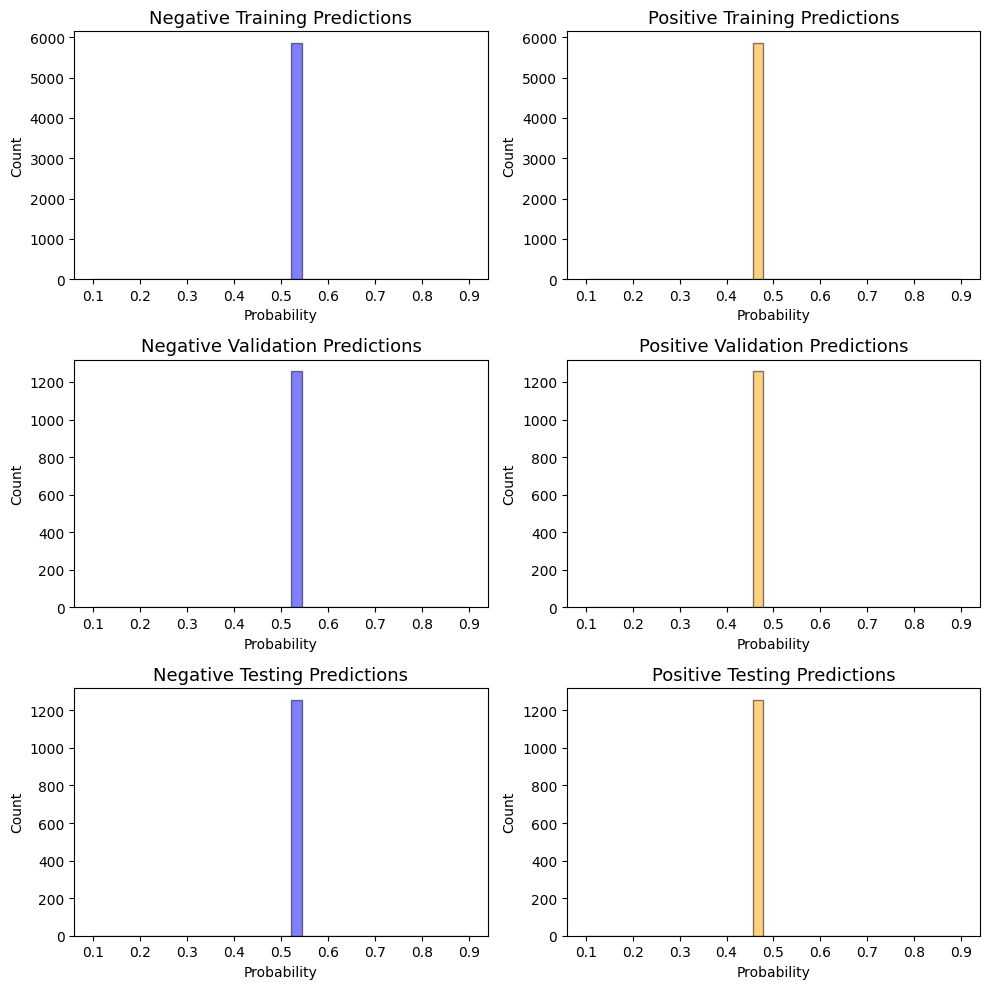

In [45]:
bins = np.linspace(0.1, 0.9, 37)  #10 bins from 0.4 to 1
##bin the probabilities
counts_neg_test, edges_neg_test = np.histogram(pred_test[:,0], bins=bins)
counts_pos_test, edges_pos_test = np.histogram(pred_test[:,1], bins=bins)

counts_neg_train, edges_neg_train = np.histogram(pred_train[:,0], bins=bins)
counts_pos_train, edges_pos_train = np.histogram(pred_train[:,1], bins=bins)

counts_neg_val, edges_neg_val = np.histogram(pred_val[:,0], bins=bins)
counts_pos_val, edges_pos_val = np.histogram(pred_val[:,1], bins=bins)

fig, axes = plt.subplots(3, 2, figsize=(10,10))
ax1, ax2, ax3, ax4, ax5, ax6 = axes.flatten()

ax1.bar(edges_neg_train[:-1], counts_neg_train, width=np.diff(edges_neg_train), 
        edgecolor='black', alpha=0.5, align='edge', color='blue')
ax1.set_title('Negative Training Predictions', fontsize=13)
ax1.set_xlabel('Probability')
ax1.set_ylabel('Count')

ax2.bar(edges_pos_train[:-1], counts_pos_train, width=np.diff(edges_pos_train), 
        edgecolor='black', alpha=0.5, align='edge', color='orange')
ax2.set_title('Positive Training Predictions', fontsize=13)
ax2.set_xlabel('Probability')
ax2.set_ylabel('Count')

ax3.bar(edges_neg_val[:-1], counts_neg_val, width=np.diff(edges_neg_val), 
        edgecolor='black', alpha=0.5, align='edge', color='blue')
ax3.set_title('Negative Validation Predictions', fontsize=13)
ax3.set_xlabel('Probability')
ax3.set_ylabel('Count')

ax4.bar(edges_pos_val[:-1], counts_pos_val, width=np.diff(edges_pos_val), 
        edgecolor='black', alpha=0.5, align='edge', color='orange')
ax4.set_title('Positive Validation Predictions', fontsize=13)
ax4.set_xlabel('Probability')
ax4.set_ylabel('Count')

ax5.bar(edges_neg_test[:-1], counts_neg_test, width=np.diff(edges_neg_test), 
        edgecolor='black', alpha=0.5, align='edge', color='blue')
ax5.set_title('Negative Testing Predictions', fontsize=13)
ax5.set_xlabel('Probability')
ax5.set_ylabel('Count')

ax6.bar(edges_pos_test[:-1], counts_pos_test, width=np.diff(edges_pos_test), 
        edgecolor='black', alpha=0.5, align='edge', color='orange')
ax6.set_title('Positive Testing Predictions', fontsize=13)
ax6.set_xlabel('Probability')
ax6.set_ylabel('Count')

plt.tight_layout()